# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : une partie qui vise à télécharger les bases de données utiles, une partie qui vise à étudier ses bases de données et à les analyser, et une partie qui vise à modéliser le problème pour tenter d'y apporter une réponse satisfiasante.

In [1]:
# !pip install cartopy
# !pip install geopy

In [1]:
import os
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial import distance

In [2]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Debug

In [3]:
# Initialiser le géocodeur
geolocator = Nominatim(user_agent="geoapi")

# Fonction pour récupérer les coordonnées
def get_coordinates(adresse):
    
    try:
        location = geolocator.geocode(adresse)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except Exception as e:
        print(f"Erreur pour l'adresse {address}: {e}")
        return pd.Series([None, None])

NameError: name 'Nominatim' is not defined

In [ ]:
from geopy.geocoders import Nominatim

# Initialiser le géocodeur
geolocator = Nominatim(user_agent="myGeocoder")

# Géocodage
adresse = "12bis Rue de Paris 78560 Le Port-Marly"
location = geolocator.geocode(adresse)
# print(f"Latitude : {location.latitude}, Longitude : {location.longitude}")
location.latitude, location.longitude

In [ ]:
from geopy.geocoders import Nominatim

# Initialiser le géocodeur
geolocator = Nominatim(user_agent="myGeocoder")

def obtenir_coordonnees(

In [ ]:
adresses_clubs_aviron[['LAT', 'LON']] = adresses_clubs_aviron['adresse'].apply(get_coordinates)
adresses_clubs_aviron

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [3]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    station_au_hasard,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    create_nearest_stations_dataframe,
)

---

Téléchargement des bases de données météo horaire, puis concaténation et nettoyage

In [4]:
# load_and_save_all_department_data(
#    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
#    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
# )

In [4]:
meteo_horaire_departement = load_data_from_disk(
    data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]


In [5]:
meteo_horaire_departement = cleaning_and_organizing(
                                df=meteo_horaire_departement,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )

Le dataframe meteo_horaire_departement contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

---

Création du dataset clubs d'aviron et récupération de leurs coordonnées GPS

In [6]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [7]:
# On applique la fonction get_coordinates à chaque adresse
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---

Création du dataset stations hydrométriques

In [8]:
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()]
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1)

---

Importation de la base de données fluviales

In [9]:
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )

---

Création des bases de données avec les stations météo et hydro les plus proches des clubs d'aviron donnés

In [10]:
stations_meteo = create_nearest_stations_dataframe(clubs_aviron, meteo_horaire_departement, filter_keyword=None)

In [11]:
stations_hydro = create_nearest_stations_dataframe(clubs_aviron, liste_stations_hydro, 'Seine')

In [12]:
liste_stations_a_récupérer = []
for element in stations_hydro['NUM_POSTE']:
    if element not in liste_stations_a_récupérer :
        liste_stations_a_récupérer.append(element)

# Voila les stations dont on doit télécharger l'historique des données hydro à la main
print("Les stations dont il faut récupérer les données dans les archives hydrométriques sont : " + ", ".join(liste_stations_a_récupérer))

Les stations dont il faut récupérer les données dans les archives hydrométriques sont : H512011001, H503011001, H501012001, H320000104, H308000101, H300000201, F712000102, F704000102, F704000101, F490000104, F449000601, F447000101, F400000301, H170001001, H080001101


In [15]:
#Cleaning des datasets et insertion dans un dictionnaire pour y avoir accès à tous en même temps
# Création de la liste des fichiers à traiter
liste_stations_a_récupérer 

# Liste contenant les fichiers CSV à traiter
fichiers_stations_hydro = []

#Path a utiliser : 
chemin_dossier = "/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/"

# Parcourir chaque numéro dans la liste
for station in liste_stations_a_récupérer:
    fichier = f"{chemin_dossier}{station}.csv"  # Construire le nom du fichier
    fichiers_stations_hydro.append(fichier)  # Ajouter le fichier à la liste

# Résultat final
print("Fichiers trouvés :", fichiers_stations_hydro)

# Dictionnaire pour stocker les DataFrames
dictionnaire_df_stations_hydro = {}


for fichier in fichiers_stations_hydro:
    # Lire le fichier
    df = pd.read_csv(fichier)
    
    # Supprimer les colonnes inutiles
    df = df.drop(columns=["Statut", "Qualification", "Méthode", "Continuité"], errors="ignore")
    print(df)
    # Convertir la colonne "Valeur (en m³/s)" en entier
    df["Valeur (en m³/s)"] = pd.to_numeric(df["Valeur (en m³/s)"].astype(str).str.replace(",", "").str.replace('"', ""), errors="coerce").fillna(0).astype(int)
    
    # Renommer dynamiquement le DataFrame
    nom_dataframe = f"df_débit_{fichier.split('.')[0]}"  # Supprime l'extension .csv du nom
    dictionnaire_df_stations_hydro[nom_dataframe] = df  # Stocker dans un dictionnaire

for nom, df in dictionnaire_df_stations_hydro.items():
    print(f"Les 5 premières lignes de {nom}:")
    print(df.head())  # Affiche les 5 premières lignes
    print()  # Ligne vide pour la lisibilité

#On a finalement un dictionnaire avec tous les dataframes des bases hydro à l'interieur, avec uniquement le débit heure par heure à chaque station.

Fichiers trouvés : ['/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H512011001.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H503011001.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H501012001.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H320000104.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H308000101.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/H300000201.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/F712000102.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/F704000102.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/F704000101.csv', '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/F490000104.csv', '/home/ony

# **Data analysis**

In [23]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

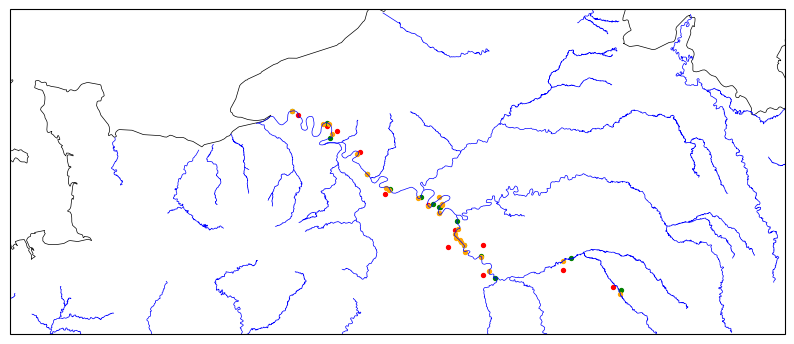

In [13]:
carte_figures(rivers, stations_meteo, stations_hydro, clubs_aviron)

---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [14]:
# On choisit une station au hasard pour les graphiques
random_station = stations_meteo["NOM_USUEL"].sample(n=1, random_state=0).iloc[0]
meteo_random_station = station_au_hasard(random_station, meteo_horaire_departement)

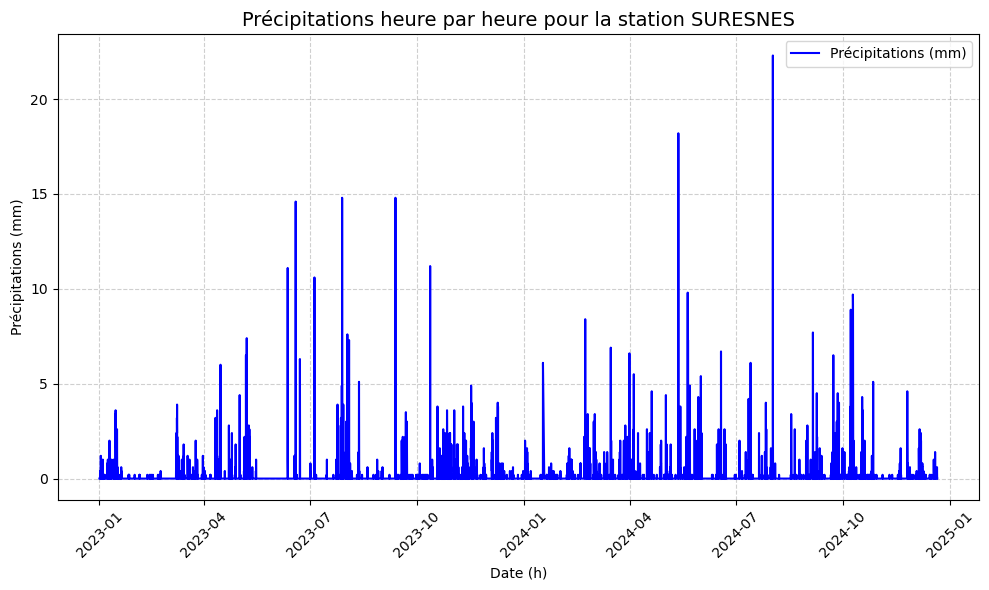

In [15]:
trace_graphique(
    x=meteo_random_station["AAAAMMJJHH"],
    y=meteo_random_station["RR1"],
    titre=f"Précipitations heure par heure pour la station {random_station}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire** est utile pour analyser la variabilité des précipitations à court terme. Toutefois, elle rend difficile la lecture des **tendances globales** à cause de l'apparente "saturation" de l'information.  

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels.

2. b. <u>Par semaine</u>

In [18]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_random_station['hebdo'] = meteo_random_station['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

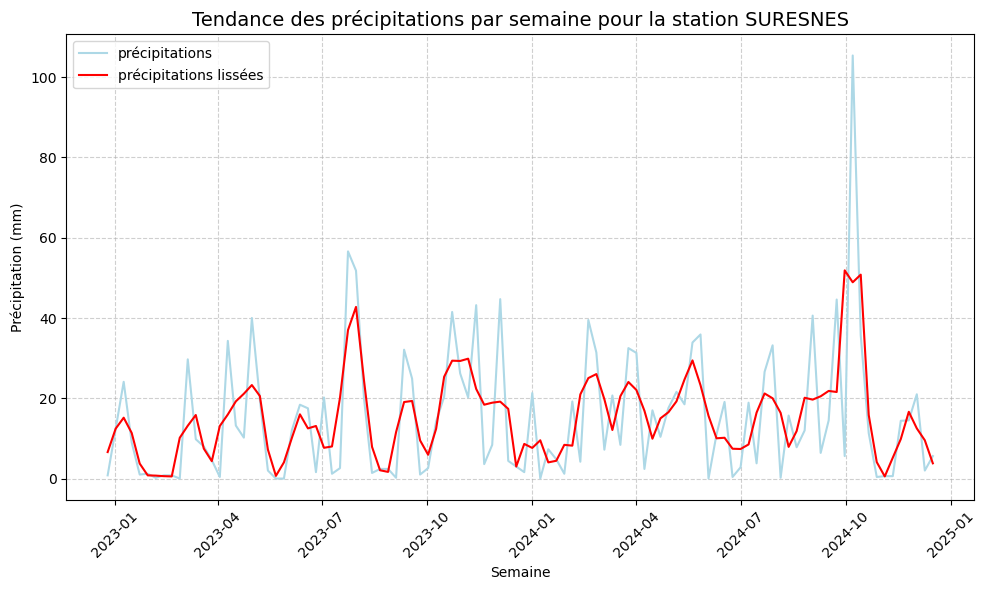

In [27]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour la station {random_station}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

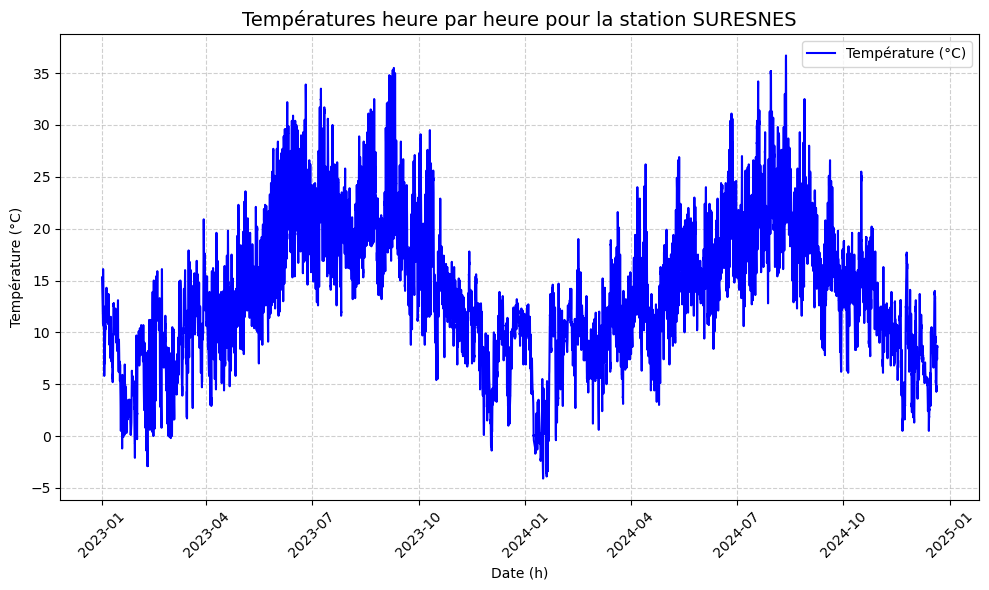

In [20]:
trace_graphique(
    x=meteo_random_station["AAAAMMJJHH"],
    y=meteo_random_station["T"],
    titre=f"Températures heure par heure pour la station {random_station}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

3. b. <u>Par semaine</u>

In [21]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

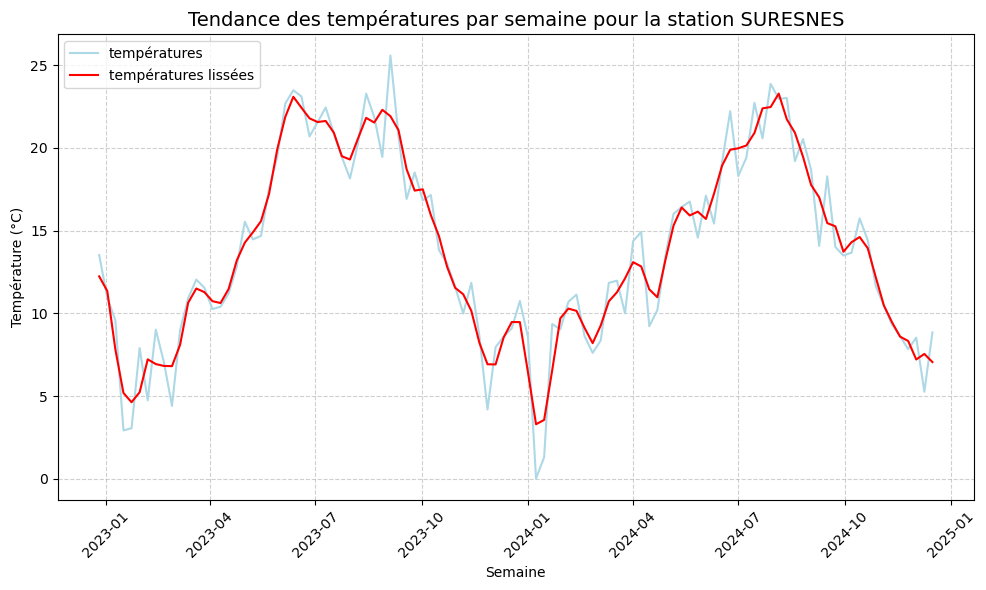

In [25]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour la station {random_station}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

# **Data modeling**